In [3]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch
from dataloader import load_data

## Load Data

In [11]:
# load data
data = load_data()
data.tail(3)

[*********************100%***********************]  2 of 2 completed


AttributeError: 'numpy.ndarray' object has no attribute '_stat_axis_number'

We plot the returns of SP500 index during COVID-19.

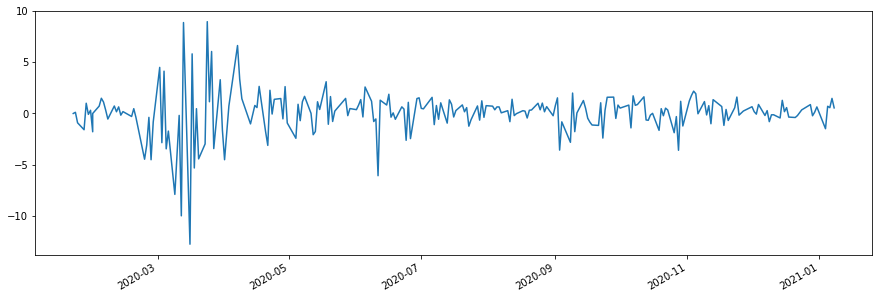

In [19]:
data['returns'] =  np.log(data.SP500 / data.SP500.shift(1)).fillna(0) * 100
data.returns.plot(figsize=(15,5))

## Part 1: Forecasting SP500 returns by GARCH model

####  Step 1

We check whether the time series is stationary, whether difference is needed. That is:

Null hypothesis $H_0$: the sequence is non-stationary 

Alternative hypothesis $H_1$: the sequence is stationary

In [20]:
t = sm.tsa.stattools.adfuller(data.returns)  # ADF test
print ("p-value: ",t[1])

p-value:  0.0013740073774273361


The p-value is less than the significance level, and the null hypothesis is rejected, Therefore. the sequence is stationary. 


#### Step 2
Next, we build $AR(p)$ model and determine the order $p$.

NameError: name 'data' is not defined

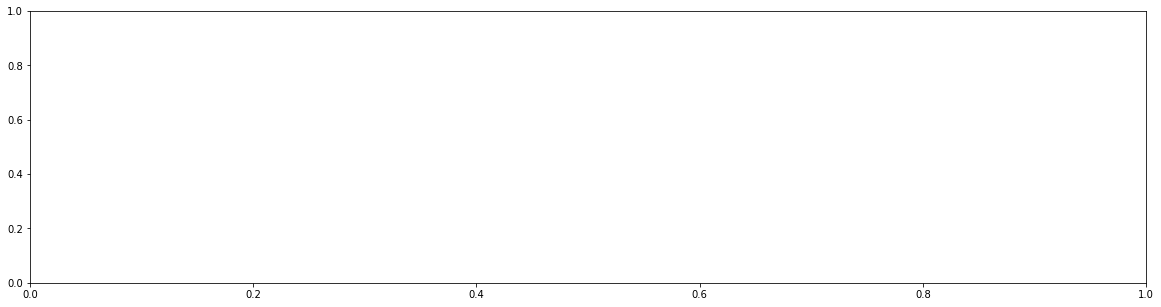

In [12]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(data.returns,lags = 20,ax=ax1)

So we choose $p=2$ and build an $AR(2)$ model. We can see the result below.

In [128]:
p = (2,0)
ar_model = sm.tsa.ARMA(data.returns,p).fit()
ar_model.summary()

C:\Users\harvey_sun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                  237
Model:                     ARMA(2, 0)   Log Likelihood                -498.489
Method:                       css-mle   S.D. of innovations              1.981
Date:                Thu, 04 Feb 2021   AIC                           1004.978
Time:                        21:53:48   BIC                           1018.851
Sample:                             0   HQIC                          1010.570
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0619      0.145      0.428      0.669      -0.221       0.345
ar.L1.returns    -0.2021      0.061     -3.292      0.001      -0.322      -0.082
ar.L2.returns     0.3136      0.061      5.108      0.000       0.193       0.434
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4922           +0.0000j            1.4922            0.5000
AR.2            2.1367           +0.0000j            2.1367            0.0000
-----------------------------------------------------------------------------
"""

#### Step 3

Let $\epsilon_t$ be the residuals

$$\epsilon_t = r_t - \hat{r}_t$$

We use Ljung-Box test to test the correlation of the sequence $\{\epsilon_t\}$  to determine whether it has the ARCH effect.

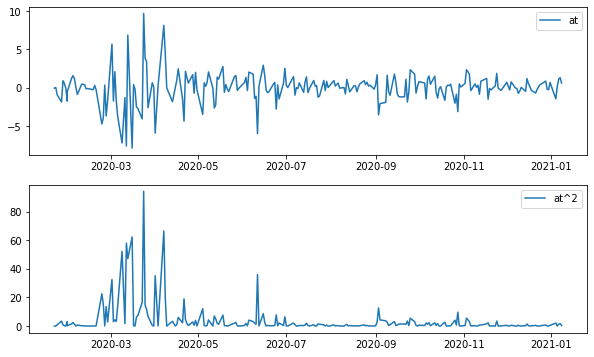

In [241]:
# Calculate the residuals
eps_t = data.returns -  ar_model.fittedvalues
eps_t2 = np.square(eps_t)

# Plot the residuals and the square of the residuals
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'ϵ_t')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='ϵ_t square')
plt.legend(loc=0)

Then perform a Ljung-Box test on the $\{\epsilon^2_t\}$  sequence: 

Null hypothesis $H_0$: the sequence has no autocorrelation

Alternative hypothesis $H_1$: the sequence has autocorrelation

In [24]:
# test first 10 autocorrelation coefficients
m = 10
# calculate autocorrelation coefficients and p-value
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True,fft=False) 
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.302172,21.915002,2.849972e-06
2.0,0.332365,48.541129,2.880234e-11
3.0,0.141981,53.420782,1.491189e-11
4.0,0.132776,57.706572,8.793653e-12
5.0,0.126883,61.637258,5.574229e-12
6.0,0.337026,89.489612,3.867575e-17
7.0,0.305134,112.419303,2.889387e-21
8.0,0.506404,175.850841,7.648347e-34
9.0,0.256891,192.245761,1.394916e-36


The p-value is less than the significance level of 0.05, and we reject the null hypothesis that the sequence has no correlation. Therefore, it has the ARCH effect.

#### Step 4

By the previous steps, we conclude that we need to use ARCH model to capture the conditional heteroskedasticity.

To determine the order of the ARCH model, we use the partial autocorrelation function PACF of $\{\epsilon^2_t\}$ sequence.

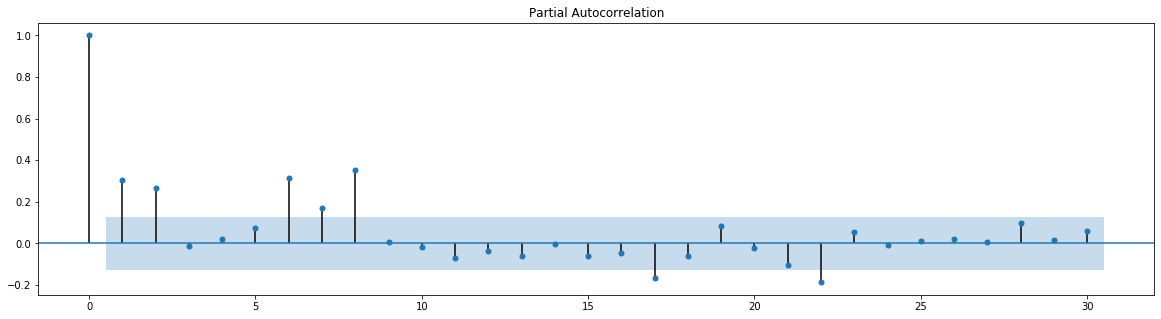

In [25]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(at2,lags = 30,ax=ax1)

From the figure above, we can build AR(8) model

$$\sigma_t^2 = a_0 + \alpha_1 \epsilon_{t-1}^2 +\alpha_2 \epsilon_{t-2}^2$$

σ2t=α0+α1a2t−1+cdots+α4a2t−m η=a2t−σ2t a2t=α0+α1a2t−1+cdots+α4a2t−m+ηt

Based on our previous analysis, we can roughly choose the mean model as the AR(2) model, and the volatility model as the ARCH(8) model.

In [170]:
am = arch.arch_model(data.returns,mean='AR',lags=0,vol='ARCH',p=2)
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 438.53104544587245
Iteration:      2,   Func. Count:     15,   Neg. LLF: 436.75272176842856
Iteration:      3,   Func. Count:     22,   Neg. LLF: 435.43233203802424
Iteration:      4,   Func. Count:     29,   Neg. LLF: 434.8810761387721
Iteration:      5,   Func. Count:     36,   Neg. LLF: 434.37606802288644
Iteration:      6,   Func. Count:     43,   Neg. LLF: 433.98612956659656
Iteration:      7,   Func. Count:     50,   Neg. LLF: 433.5144654607859
Iteration:      8,   Func. Count:     57,   Neg. LLF: 433.35596649681503
Iteration:      9,   Func. Count:     63,   Neg. LLF: 433.2777588182139
Iteration:     10,   Func. Count:     69,   Neg. LLF: 433.15570502309737
Iteration:     11,   Func. Count:     75,   Neg. LLF: 433.1424029459097
Iteration:     12,   Func. Count:     81,   Neg. LLF: 433.14159972405446
Iteration:     13,   Func. Count:     87,   Neg. LLF: 433.14156670439127
Optimization terminated successfully.    (Exit mode 0)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.003
Mean Model:                        AR   Adj. R-squared:                 -0.003
Vol Model:                       ARCH   Log-Likelihood:               -433.142
Distribution:                  Normal   AIC:                           874.283
Method:            Maximum Likelihood   BIC:                           888.155
                                        No. Observations:                  237
Date:                Thu, Feb 04 2021   Df Residuals:                      233
Time:                        22:04:10   Df Model:                            4
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.1708  8.985e-02      1.901  5.730e-02 [-5.299e-03,  0.347]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9952      0.259      3.841  1.225e-04   [  0.487,  1.503]
alpha[1]       0.1593  5.015e-02      3.176  1.493e-03 [6.098e-02,  0.258]
alpha[2]       0.5594      0.139      4.031  5.566e-05   [  0.287,  0.831]
==========================================================================

Covariance estimator: robust
"""

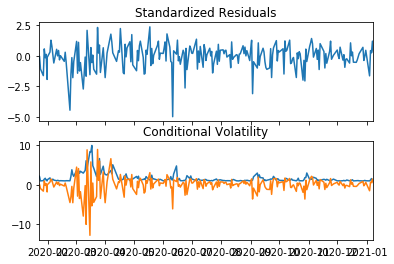

In [172]:
res.plot()
plt.plot(data.returns)

#### Step 5

We use garch(1,1) to fit the residual.

In [173]:
gm = arch.arch_model(train,mean='AR',lags=0,vol='GARCH',p=2,q=1) 
res2 = gm.fit()
res2.summary

Iteration:      1,   Func. Count:      7,   Neg. LLF: 425.35875125474536
Iteration:      2,   Func. Count:     20,   Neg. LLF: 424.9313977676263
Iteration:      3,   Func. Count:     29,   Neg. LLF: 423.8904602606177
Iteration:      4,   Func. Count:     37,   Neg. LLF: 423.1829573343359
Iteration:      5,   Func. Count:     45,   Neg. LLF: 420.98358550787293
Iteration:      6,   Func. Count:     53,   Neg. LLF: 420.491275186617
Iteration:      7,   Func. Count:     61,   Neg. LLF: 419.8376795157584
Iteration:      8,   Func. Count:     69,   Neg. LLF: 419.5542984962601
Iteration:      9,   Func. Count:     76,   Neg. LLF: 419.30108198511664
Iteration:     10,   Func. Count:     84,   Neg. LLF: 419.23854789033174
Iteration:     11,   Func. Count:     91,   Neg. LLF: 419.16847326885716
Iteration:     12,   Func. Count:     98,   Neg. LLF: 419.15291859576877
Iteration:     13,   Func. Count:    105,   Neg. LLF: 419.1481067836921
Iteration:     14,   Func. Count:    112,   Neg. LLF: 419.1

<bound method ARCHModelResult.summary of                            AR - GARCH Model Results                           
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -419.139
Distribution:                  Normal   AIC:                           848.278
Method:            Maximum Likelihood   BIC:                           865.403
                                        No. Observations:                  227
Date:                Thu, Feb 04 2021   Df Residuals:                      222
Time:                        22:04:45   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.113

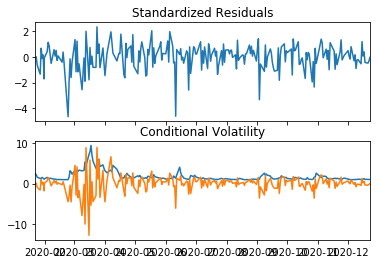

In [175]:
res2.plot()
plt.plot(data.returns)

##  Part 2: Forecasting VIX using ARX model, COVID as an exogenous variable

We want to add COVID as an exogenous variable in the GARCH model.Unfortunately, Python has no packages that can solve GARCH-X model, so we will change to ARX model that use COVID as an exogenous variable to fit US VIX index.

First we plot the graph for VIX index and log of the COVID cases growth in US.

2020-02-05    15.15
2020-02-06    14.96
2020-02-07    15.47
2020-02-10    15.04
2020-02-11    15.18
Name: VIX, dtype: float64
2020-02-05    15.320776
2020-02-06    13.257563
2020-02-07    11.177018
2020-02-10     7.526243
2020-02-11     6.457128
Name: cases_growth_US, dtype: float64


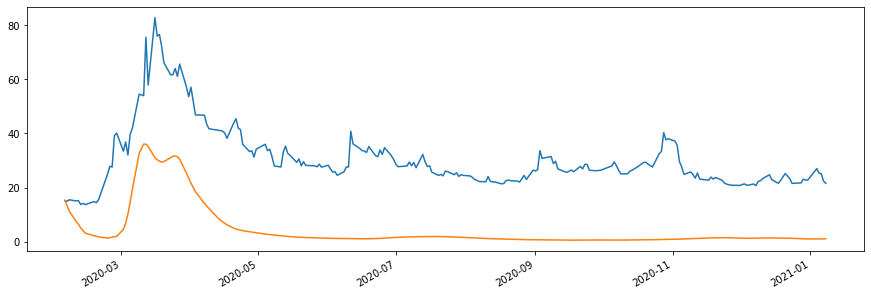

In [231]:
sp500_vol = data.VIX
sp500_vol = sp500_vol.iloc[11:].fillna(method='ffill')
covid_us = data.cases_growth_US * 100
covid_us = covid_us.iloc[11:]
print(sp500_vol.head(5))
print(covid_us.head(5))
sp500_vol.plot(figsize=(15,5))
plt.plot(covid_us)

Then we use ARX to fit the data to see whether the model is appropriate.

In [238]:
from arch.univariate import ARX, Normal
am = ARX(y = sp500_vol, x = covid_us, lags=1, distribution=Normal())
res = am.fit()

In [239]:
res.summary

<bound method ARCHModelResult.summary of                     AR-X - Constant Variance Model Results                    
Dep. Variable:                    VIX   R-squared:                       0.913
Mean Model:                      AR-X   Adj. R-squared:                  0.912
Vol Model:          Constant Variance   Log-Likelihood:               -599.397
Distribution:                  Normal   AIC:                           1206.79
Method:            Maximum Likelihood   BIC:                           1220.46
                                        No. Observations:                  225
Date:                Fri, Feb 05 2021   Df Residuals:                      221
Time:                        00:02:22   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          5.1072  

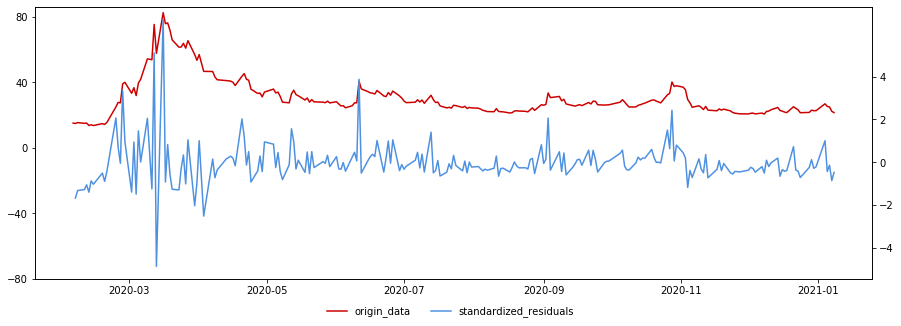

In [268]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5),)
ax2 = ax1.twinx()
blue = tuple(np.array([78, 145, 224]) / 255)
red = tuple(np.array([205, 0, 0]) / 255)
ax1.plot(sp500_vol,label='origin_data',color=red)
ax2.plot(res.std_resid,label='standardized_residuals',color=blue)
ax1.set_yticks(np.arange(-80,120,40))
ax2.set_yticks(np.arange(-4,6,2))
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend1 = fig.legend(handles1+handles2, labels1+labels2,loc='lower center',ncol=2,frameon=False)
plt.show()

By the results above, the model can describe the VIX to some extend, but it obviously has the problem of conditional heteroskedasticity.